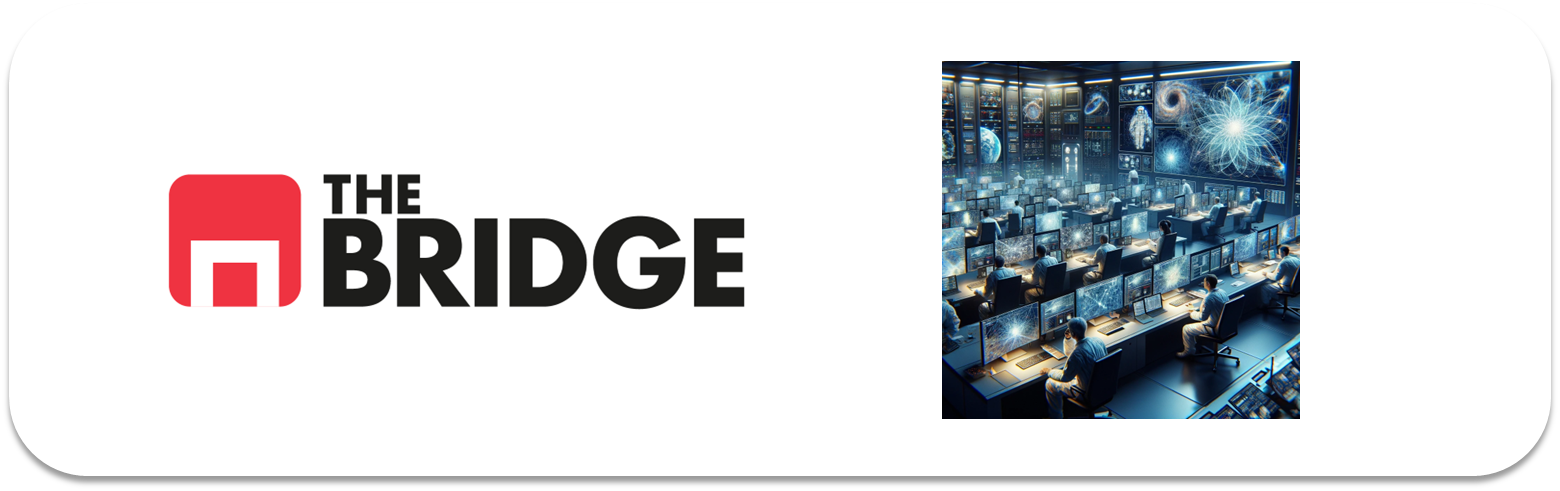

## PRACTICA OBLIGATORIA: **Transfer Learning y Fine Tuning con CNN**

* La práctica obligatoria de esta unidad consiste en un repetir el ejercicio de construcción de un modelo de clasificación de paisajes pero usando un modelo preentrenado. Descarga este notebook en tu ordenador y trabaja en local. Ten en cuenta que tendrás que descar los directorios de imágenes y datos adicionales, si los hubiera.
* Recuerda que debes subirla a tu repositorio personal antes de la sesión en vivo para que puntúe adecuadamente.  
* Recuerda también que no es necesario que esté perfecta, sólo es necesario que se vea el esfuerzo. 
* Esta práctica se resolverá en la sesión en vivo correspondiente y la solución se publicará en el repo del curso. 

### Ejercicio 0

Importa los paquetes y módulos que necesites a lo largo del notebook.

In [1]:
import os
import numpy as np
import pandas as pd

import matplotlib.pyplot as plt
import seaborn as sns

import cv2
from skimage.io import imread
from sklearn.utils import shuffle
from sklearn.metrics import classification_report, confusion_matrix

from keras import layers
from keras.callbacks import EarlyStopping, ModelCheckpoint
from keras.optimizers import Adam
from keras.applications import MobileNetV2
from tensorflow.keras import Model

2025-07-17 02:40:14.398006: I tensorflow/core/util/port.cc:153] oneDNN custom operations are on. You may see slightly different numerical results due to floating-point round-off errors from different computation orders. To turn them off, set the environment variable `TF_ENABLE_ONEDNN_OPTS=0`.
2025-07-17 02:40:14.503722: E external/local_xla/xla/stream_executor/cuda/cuda_fft.cc:467] Unable to register cuFFT factory: Attempting to register factory for plugin cuFFT when one has already been registered
E0000 00:00:1752712814.542225   88876 cuda_dnn.cc:8579] Unable to register cuDNN factory: Attempting to register factory for plugin cuDNN when one has already been registered
E0000 00:00:1752712814.553015   88876 cuda_blas.cc:1407] Unable to register cuBLAS factory: Attempting to register factory for plugin cuBLAS when one has already been registered
W0000 00:00:1752712814.632075   88876 computation_placer.cc:177] computation placer already registered. Please check linkage and avoid linking 

### Objetivo del ejercicio

Comparar una red convolucional hecha ad-hoc frente a los modelos preentrenados y ajustados con fine tuning y transfer learning. Para ello emplea el dataset de paisajes del conjunto de ejercicios de la unidad anterior.


### Se pide

1. Preparar los datos del modelo y las funciones de visualización, copia para ello todo lo que necesites de las soluciones del ejercicio de clasificación de paisajes de la unidad anterior.

2. Escoger entre uno de los modelos VGG-19, InceptionV3 y MobileNetV2 (todos en https://keras.io/api/applications/) (Se aconseja este último si no tenemos un ordenador muy potente). Si no te haces con estos puedes recurrir a la ResNetV50.

4. Hacer un transfer-learning con una cabeza de como mucho 2 capas densas ocultas y una de salida. Mostrar la evaluación contra test, el report de clasificación y la matriz de confusión.

5. Hacer un fine-tuning con la misma cabeza diseñada en el punto anterior. Mostrar la evaluación contra test, el report de clasificación y la matriz de confusión.

6. Comparar los resultados con los obtenidos con la red convolucional del ejercicio mencionado.

EXTRA:
- Repetir el transfer learning empleando aumentado de imágenes.



## 1. Datos

### Carga de datos

Primero recolectamos las imágenes, las redimensionamos y las asignamos a nuestro juego X,y.  
Para ello me valgo de la función creada en el workout.

In [2]:
path_train = './data/seg_train'
path_test = './data/seg_test'

folders = os.listdir(path_train)

def read_data(directorio, reshape_dim=(96,96)):     # diensiono a 96 pixeles ya que es el tamaño minimo para los pesos entrenados de MobileNet
    X, y = [], []                                   # 128 pixeles me rompe el kernel 
    for folder in folders:
        path_folder = '/'.join([directorio, folder])
        for file in os.listdir(path_folder):
            image = imread('/'.join([path_folder, file]))
            image = cv2.resize(image, reshape_dim)

            X.append(image)
            y.append(folder)  

    return np.array(X),np.array(y)

In [3]:
X_train, y_train = read_data(path_train)
X_test, y_test = read_data(path_test)

### Visualización

A continuación, visualizamos algunas imágenes aleatorias, para comprobar resolución y etiquetas.  
Igualmente, reutilizo una función del workout.

In [4]:
def visualiza(num_images:int, n_col=5, set_image=X_train, set_labels=y_train):
    '''
    num_images: número de imágenes a mostrar \n
    n_col:      número de columnas a mostrar
    '''
    num_list = list(np.random.randint(0, set_image.shape[0], num_images))
    images = set_image[num_list]
    labels = set_labels[num_list]

    columns = n_col if len(images) > n_col else len(images)
    rows = len(images) // 5 if len(images)%5 == 0 else (len(images) // 5) +1
    fig, ax = plt.subplots(rows, columns, figsize=(columns*3, rows*2))
    ax = ax.flatten()
    for index, image in enumerate(images):
        ax[index].imshow(image, cmap='Greys')
        ax[index].axis('off')
        ax[index].set_title(labels[index])

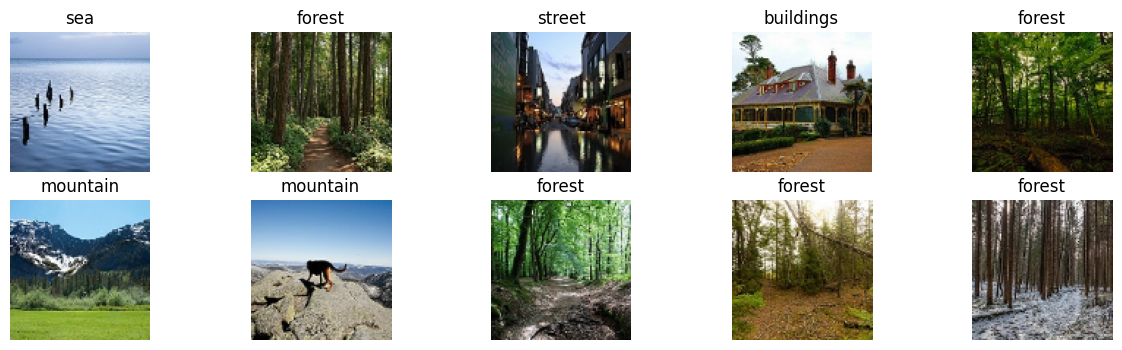

In [5]:
visualiza(10)

Comprobamos dimensiones del dataset

In [6]:
X_train.shape

(14034, 96, 96, 3)

Y por último, inspecciono la distribución de las categorías del target.  
En este caso, podemos decir que está bastante equilibrado entre 6 categorias. 

In [7]:
pd.Series(y_train).value_counts(True)

mountain     0.178994
glacier      0.171298
street       0.169731
sea          0.162035
forest       0.161821
buildings    0.156121
Name: proportion, dtype: float64

### Transformación

Antes de entrar en faena, terminamos de preparar los datos.  
Para ello, escalamos las X y codificamos las y.  
Por último, *barajamos* el dataset de entrenamiento. 

In [8]:
X_train = X_train / 255
X_test = X_test / 255

In [9]:
dic_clases = {value:index for index, value in enumerate(np.unique(y_train))}

y_train_num = pd.Series(y_train).map(dic_clases)
y_test_num = pd.Series(y_test).map(dic_clases)

In [10]:
X_shuffle, y_shuffle = shuffle(X_train, y_train_num)

## 2. Transfer Learning

### Modelo

Para mi caso de estudio emplearé como modelo base *MobileNetV2*, ya que según el [cuadro comparativo](https://keras.io/api/applications/), ofrece una precisión un poco menor al resto (71,3 % para predicciones exactas), pero una precisión general similar (90 % para predicción entre las 5 categorías más probables), teniendo como puntos a favor el menor número de parámetros a entrenar (3.5M frente a los 23.9M de *InceptionV3*), con una profundidad similar a *ResNet50* y un tiempo por paso de predicción de casi la mitad la resto (25.9 ms/paso).  

En la descripción nos dicen que:

>[MobileNetV2](https://keras.io/api/applications/mobilenet/#mobilenetv2-function) is very similar to the original MobileNet, except that it uses inverted residual blocks with bottlenecking features. It has a drastically lower parameter count than the original MobileNet. MobileNets support any input size greater than 32 x 32, with larger image sizes offering better performance.

Por tanto, comprobemos cuanto de efectivo es.

In [11]:
# Descargamos el modelo sin cabeza pero con los pesos entrenados

base_model = MobileNetV2(input_shape=(96, 96, 3), weights='imagenet', include_top=False)

2025-07-17 02:40:30.653508: E external/local_xla/xla/stream_executor/cuda/cuda_platform.cc:51] failed call to cuInit: INTERNAL: CUDA error: Failed call to cuInit: UNKNOWN ERROR (303)


In [12]:
# Congelamos los pesos de las capas de convolución

for layer in base_model.layers:
    layer.trainable = False

In [13]:
# Creamos la red neuronal, juntamos todo y compilamos

x = layers.Flatten()(base_model.output)
x = layers.Dense(512,activation='relu')(x)
x = layers.Dropout(rate=0.5)(x)
x = layers.Dense(6, activation='softmax')(x)

model = Model(base_model.inputs,x)
model.compile(optimizer = "adam", loss = 'sparse_categorical_crossentropy', metrics = ['acc'])

model.summary()

Model: "functional"

┏━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┓
┃ Layer (type)        ┃ Output Shape      ┃    Param # ┃ Connected to      ┃
┡━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━┩
│ input_layer         │ (None, 96, 96, 3) │          0 │ -                 │
│ (InputLayer)        │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ Conv1 (Conv2D)      │ (None, 48, 48,    │        864 │ input_layer[0][0] │
│                     │ 32)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ bn_Conv1            │ (None, 48, 48,    │        128 │ Conv1[0][0]       │
│ (BatchNormalizatio… │ 32)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ Conv1_relu (ReLU)   │ (None, 48, 48,    │          0 │ bn_Conv1[0][0]    │
│                     │ 32)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ expanded_conv_dept… │ (None, 48, 48,    │        288 │ Conv1_relu[0][0]  │
│ (DepthwiseConv2D)   │ 32)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ expanded_conv_dept… │ (None, 48, 48,    │        128 │ expanded_conv_de… │
│ (BatchNormalizatio… │ 32)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ expanded_conv_dept… │ (None, 48, 48,    │          0 │ expanded_conv_de… │
│ (ReLU)              │ 32)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ expanded_conv_proj… │ (None, 48, 48,    │        512 │ expanded_conv_de… │
│ (Conv2D)            │ 16)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ expanded_conv_proj… │ (None, 48, 48,    │         64 │ expanded_conv_pr… │
│ (BatchNormalizatio… │ 16)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ block_1_expand      │ (None, 48, 48,    │      1,536 │ expanded_conv_pr… │
│ (Conv2D)            │ 96)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ block_1_expand_BN   │ (None, 48, 48,    │        384 │ block_1_expand[0… │
│ (BatchNormalizatio… │ 96)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ block_1_expand_relu │ (None, 48, 48,    │          0 │ block_1_expand_B… │
│ (ReLU)              │ 96)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ block_1_pad         │ (None, 49, 49,    │          0 │ block_1_expand_r… │
│ (ZeroPadding2D)     │ 96)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ block_1_depthwise   │ (None, 24, 24,    │        864 │ block_1_pad[0][0] │
│ (DepthwiseConv2D)   │ 96)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ block_1_depthwise_… │ (None, 24, 24,    │        384 │ block_1_depthwis… │
│ (BatchNormalizatio… │ 96)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ block_1_depthwise_… │ (None, 24, 24,    │          0 │ block_1_depthwis… │
│ (ReLU)              │ 96)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ block_1_project     │ (None, 24, 24,    │      2,304 │ block_1_depthwis

 Total params: 8,159,814 (31.13 MB)

 Trainable params: 5,901,830 (22.51 MB)

 Non-trainable params: 2,257,984 (8.61 MB)

## Entrenamiento

Para el entrenamiento estableceremos un *early stopping* para no realizar todas las épocas sino mejora el rendimiento, y un *model checkpoint* para no perder los progresos en caso de que el kernel o la CPU colapse. 

In [ ]:
early = EarlyStopping(patience= 5, restore_best_weights= True)
checkpoint = ModelCheckpoint(filepath='./model/checkpoint.model.keras',                 # fichero donde se guardará el modelo 
                            monitor='val_accuracy', mode='max', save_best_only=True)    # frecuencia con la que se guardará, en este caso, cada vez que 'val_accuracy' sea máximo
batch_size = 64                                                                         # cubiertas las espaldas, démosle un poco de más caña

from time import time
t_zero = time()
history = model.fit(X_shuffle, 
                    y_shuffle,
                    batch_size = batch_size,
                    validation_split=0.2,
                    epochs=30,                                                          # En los ejercicios de la unidad anterior llegados a este punto el pescado estaba vendido
                    callbacks=[early, checkpoint])                                      # Estableciendo los callbacks, podemos ejecutar todo directamente sin miedo al éxito
print((time() - t_zero)/ 60)                                                            # minutos de ejecución